# Backend Results

## Experiment 3 - Alternate Approach
- Seeing which algorithm **converges faster**, given a particular unitary size and given error threshold
- <font color = 'green'>Means, let us say the algorithm stopped at $x$ cost. Its target cost, in this iteration, is let's say $y$. Then, which algorithm actually stopped **closer** to the target cost, given the same iterations and resolution is the aim of this experiment.</font>
- Thresholds range from [0.001,0.3] with doubling the threshold at each iteration. 
- Resolution is 30 and max iterations is 12.

In [28]:
error = 0.002
thresholds, targets = [], []
while error < 0.4:
    thresholds.append(error)
    targets.append(round(1-error, 3))
    error *= 2
print("Threshold :", thresholds)
print("Target costs :", targets)

Threshold : [0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256]
Target costs : [0.998, 0.996, 0.992, 0.984, 0.968, 0.936, 0.872, 0.744]


### Metrics Plotted
- The cost returned by the algorithm is plotted in each case 
- Along with cost, the average error from the **closest eigenvalue** is calculated.
- Note that each trial with given error threshold is executed 4 times to get a good estimate of the result. 

### Imports

In [8]:
from qiskit import IBMQ
from qiskit import QuantumCircuit, execute, transpile, Aer
from qiskit.extensions import UnitaryGate, Initialize
from qiskit.quantum_info import Statevector
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from time import sleep
import sys
import os
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
%matplotlib inline

IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-research')
bogota = provider.get_backend('ibmq_bogota')
sim = Aer.get_backend('qasm_simulator')

In [9]:
from normal_SPEA import SPEA
from changed_SPEA import global_max_SPEA

### Plotter function

In [10]:
def generate_plots(unitary_size, costs, overlaps, errors_eigen, errors_cost, algorithm):
    import random
    colors = ['red', 'brown', 'cyan', 'green',
              'grey', 'blue', 'purple', 'black', 'orange']
    c1, c2, c3, c4 = random.sample(colors, 4)

    # plot
    os.makedirs("Experiment_3/"+str(unitary_size) +
                "_qubit(random)(backend)/", exist_ok=True)
    # plot 1
    fig = plt.figure(figsize=(13, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title(str(unitary_size)+" qubit "+algorithm +
                  " Cost vs Error threshold", fontsize=16)
    ax1.set_xlabel("Target costs ", fontsize=15)
    ax1.set_ylabel("Metrics Returned for unitary ", fontsize=15)
    # plot metrics
    ax1.plot(targets, costs, label='Costs of Unitary',
             marker='o', color=c1, alpha=0.7)
    ax1.plot(targets, overlaps, label='Average overlap from nearest eigenvector',
             marker='s', color=c2, alpha=0.6)
    ax1.plot()
    ax1.legend(loc='best')
    ax1.grid()
    # plot 2
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title(str(unitary_size)+" qubit "+algorithm +
                  " % Errors v/s thresholds", fontsize=16)
    ax2.set_xlabel("Target Costs", fontsize=15)
    ax2.set_ylabel("% errors", fontsize=15)
    # plot errors
    ax2.plot(targets, errors_eigen, label='Average error from nearest eigenvalue',
             marker='o', color=c3, alpha=0.6)
    ax2.plot(targets, errors_cost, label='Average deviation from desired cost',
             marker='s', color=c4, alpha=0.7)
    ax2.legend(loc='best')
    ax2.grid()
    # save axure
    fig.savefig("Experiment_3/"+str(unitary_size)+"_qubit(random)(backend)/" +
                algorithm+" Algorithm (alternate).JPG", dpi=200)

### Result Generator

In [26]:
def get_results(eig_vals, eig_vect, bases, basis_indices, unitary, algorithm, experiments):
    '''Return the results of running the algorithm for this particular unitary matrix'''
    costs_g = []
    errors_eig_g = []
    max_overlaps_g = []
    errors_costs_g = []
    # find how the cost converges with increasing iterations
    for error, target in zip(thresholds, targets):
        costs = []
        errors_eig = []
        errors_costs = []
        overlaps = []
        
        i = 0
        # run the experiments ...
        while len(costs) < experiments:
            if algorithm == 'original':
                spea = SPEA(unitary, resolution=30, max_iters=10)
            else:
                spea = global_max_SPEA(unitary, resolution=30, max_iters=10)

            result = spea.get_eigen_pair(
                progress=False, backend=bogota, target_cost=target,
                basis=bases[i], basis_ind=basis_indices[i], algo='alternate', randomize=False,shots=200)
            # results
            theta = result['theta']
            res_state = result['state']

            # get the results
            if result['cost'] < 0.70:
                continue

            i+=1 
            # find the abs difference in this theta with the closest eigenvalue
            # and append that to the errors ...
            min_error = 1e5
            for e in eig_vals:
                error = abs(e - theta)
                if error < min_error:
                    min_error = error
                    perc_error = ((error)/e)*100

            # get costs
            costs.append(result['cost'])
            # get eigenvalue error
            errors_eig.append(perc_error)

            # append the perc error from original target cost
            if target >= result['cost']:
                deviation = abs(target - result['cost'])/(target)
            else:  # if we have stopped with a better cost, no sense of deviation
                deviation = 0
            errors_costs.append(deviation*100)

            # find overlaps
            max_overlap = -1
            for k in eig_vect:
                dot = np.linalg.norm(np.dot(k, res_state.conjugate().T))**2
                max_overlap = max(max_overlap, dot)
            overlaps.append(max_overlap)
        print(costs, errors_costs)
        print("Result with", target, " target cost :")
        print("AVG. COST :", np.average(costs))
        print("AVG. EIGENVALUE ERROR :", np.average(errors_eig))
        print("AVG. DEVIATION FROM TARGET COST", np.average(errors_costs))

        # append the average result of your algorithm ...
        costs_g.append(np.average(costs))
        errors_eig_g.append(np.average(errors_eig))
        errors_costs_g.append(np.average(errors_costs))
        max_overlaps_g.append(np.average(overlaps))

    return costs_g, errors_eig_g, errors_costs_g, max_overlaps_g

## 2 - qubit unitary


In [22]:
unit_2 = unitary_group.rvs(4)
unit_2

array([[-0.79649848+0.18219131j,  0.40358364-0.27672868j,
         0.16117637+0.07254986j,  0.23362166-0.08436585j],
       [ 0.23740687-0.42800646j, -0.02963973-0.75429494j,
         0.39065399-0.02402369j,  0.09889995+0.1662534j ],
       [-0.24928427+0.06096331j, -0.00107852-0.16895111j,
        -0.21502862-0.19959412j, -0.66263205+0.61679723j],
       [ 0.0417636 -0.15887594j,  0.11814958-0.38496382j,
        -0.85317585-0.03983548j,  0.11251178-0.26211251j]])

- Generating eigenvalues to benchmark against


In [23]:
eig_vals2, eig_vect2 = np.linalg.eig(unit_2)
eig_vals2 = np.angle(eig_vals2)
e = []
for k in eig_vals2:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals2 = np.array(e)
print("Eigenstates :", eig_vect2)
print("Eigenvalues :", eig_vals2)

Eigenstates : [[ 0.83452004+0.j         -0.09523063+0.41680627j  0.3187381 +0.1100424j
   0.06008352+0.05887817j]
 [-0.18745159-0.02103148j -0.14796578-0.35392152j  0.86308816+0.j
  -0.01738267+0.26840628j]
 [ 0.1151535 +0.38350339j  0.61817049+0.j          0.04350635-0.32907364j
  -0.51984315+0.27768852j]
 [-0.12466584+0.30351135j  0.52165463+0.12566244j  0.13652943+0.11204004j
   0.75712049+0.j        ]]
Eigenvalues : [0.43174567 0.49207314 0.76869591 0.91550334]


### Generating Basis

In [24]:
bases2 , basis_indices2 = [], []
for _ in range(4):
    sample = unitary_group.rvs(4)
    basis = []
    for k in sample:
        basis.append(np.array(k, dtype=complex))
    ind = np.random.choice(range(4))
    bases2.append(basis)
    basis_indices2.append(ind)
print("Basis set :",bases2)
print("Basis indices :",basis_indices2)

Basis set : [[array([-0.43932591+0.41483178j,  0.66677919+0.27849641j,
       -0.08757463+0.00536249j, -0.10839436-0.30545899j]), array([-0.20012147+0.49877896j, -0.1822852 -0.06659029j,
       -0.42194614-0.05063556j,  0.55528157+0.42961455j]), array([0.30906966+0.30387471j, 0.08419583+0.30973348j,
       0.61935552-0.50749238j, 0.18719713+0.18143812j]), array([ 0.27212442+0.29010808j, -0.31889249+0.48524933j,
       -0.40172728-0.09573315j, -0.57419387+0.06616664j])], [array([-0.30277353+0.54824269j,  0.08565378+0.55561365j,
        0.2725551 +0.43913509j,  0.15470287+0.02561554j]), array([ 0.40678003-0.37139826j,  0.23121591-0.07272273j,
       -0.00575011+0.7536986j ,  0.07419993+0.25346333j]), array([-0.19341859+0.0194406j ,  0.13829429-0.06375566j,
        0.23632287+0.03671137j, -0.87291335+0.34618965j]), array([-0.26862915+0.44090949j,  0.12776627-0.76530595j,
       -0.15317754+0.29003423j,  0.05974895-0.14236097j])], [array([-0.00962099-0.77687592j,  0.504564  +0.22708721j,
 

#### Algorithm 1

In [ ]:
costs_2qubit_b, errors_eig_2qubit_b, errors_costs_2qubit_b, max_overlaps_2qubit_b = get_results(
    eig_vals2, eig_vect2, bases2, basis_indices2, unit_2, 'original', 4)

In [ ]:
generate_plots(2, costs_2qubit_b, max_overlaps_2qubit_b,
               errors_eig_2qubit_b, errors_costs_2qubit_b, "Original")

#### Algorithm 2

In [53]:
costs_2qubit_c, errors_eig_2qubit_c, errors_costs_2qubit_c, max_overlaps_2qubit_c = get_results(
    eig_vals2, eig_vect2, basis2, ind2, unit_2, 'modified', 4)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
[0.9609375, 0.83203125, 0.673828125, 0.921875] [3.713677354709419, 16.630135270541082, 32.48215180360721, 7.627755511022044]
Result with 0.998  target cost :
AVG. COST : 0.84716796875
AVG. EIGENVALUE ERROR : 14.653426763763985
AVG. DEVIATION FROM TARGET COST 15.113429984969939
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
[0.841796875, 0.740234375, 0.912109375, 0.890625] [15.482241465863453, 25.679279618473892, 8.422753514056225, 10.579819277108433]
Result with 0.99

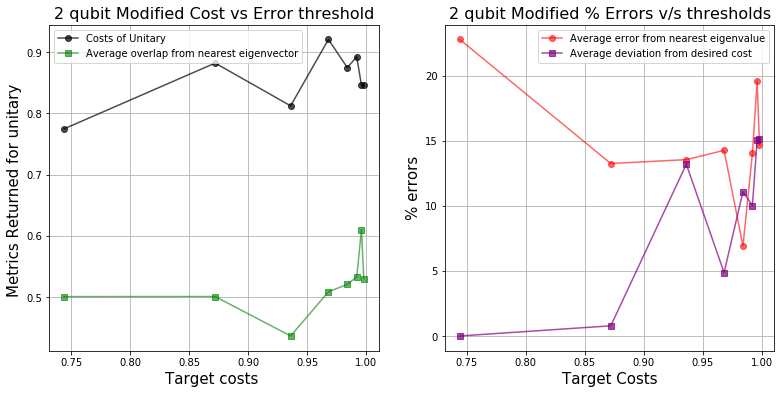

In [54]:
generate_plots(2, costs_2qubit_c, max_overlaps_2qubit_c,
               errors_eig_2qubit_c, errors_costs_2qubit_c, "Modified")

### Inference
- The inference from these plots is that the algorithms perform fairly similarly when run against each other. 
- One main advantage of the global maximum approach lies in the fact that there is a speedup incurred in the running of the circuits on actual quantum computers. **Global_max** approach contains independent circuits which can be run as a particular job so as to <font color ='orange'>reduce the **network latency** and **API call time** on the actual backends.</font>

## 3 - qubit unitary

In [55]:
unit_3 = unitary_group.rvs(8)
unit_3

array([[-0.07450835-5.73338803e-03j,  0.03716449-2.58946848e-01j,
         0.29343464+5.46297143e-01j,  0.27542622+8.35837413e-02j,
        -0.02343625-1.34804498e-01j, -0.22456874-3.63622482e-01j,
        -0.33635609-4.39777711e-02j,  0.28526456+2.46518547e-01j],
       [-0.02463897-1.31814845e-01j,  0.36108071+3.54818046e-02j,
         0.38040727-2.57698549e-01j,  0.03516214-2.29015994e-01j,
         0.58181656-8.49352113e-02j, -0.08899418-1.35974282e-02j,
        -0.07785706-6.17890028e-02j, -0.34590523+3.19714268e-01j],
       [ 0.37293379-5.33233453e-04j,  0.44214977-6.69063225e-02j,
        -0.14840416+2.49774824e-01j,  0.37051253-2.04989437e-01j,
        -0.0017178 +2.32349424e-03j,  0.09484406+4.11415748e-01j,
         0.23099135+3.43844663e-01j,  0.19117724+1.04087528e-01j],
       [-0.02302645+2.37996361e-01j, -0.35185137+4.37796016e-02j,
        -0.17735739+2.35071748e-01j, -0.0198246 -2.08315905e-01j,
         0.29320232-2.04303765e-01j, -0.35364972-2.24543242e-01j,
       

In [56]:
eig_vals3, eig_vect3 = np.linalg.eig(unit_3)
eig_vals3 = np.angle(eig_vals3)
e = []
for k in eig_vals3:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals3 = np.array(e)
print("Eigenstates :", eig_vect3)
print("Eigenvalues :", eig_vals3)

Eigenstates : [[ 0.15375062+0.40819369j -0.28697288-0.31592332j  0.24887739+0.26382225j
  -0.12483038+0.19665677j -0.30428685+0.05147094j -0.02996298-0.32061789j
   0.23377171-0.42893659j  0.03311578+0.05579617j]
 [-0.15683605+0.37268114j  0.04564973-0.03073394j  0.26281441-0.27275645j
   0.59782761+0.j         -0.09467633+0.01341126j -0.00246067-0.31976031j
   0.03712057+0.39647749j -0.0057311 -0.25023196j]
 [-0.01260367+0.1077381j   0.14094085+0.35747592j -0.36022074+0.12204962j
   0.33418987+0.1448115j   0.24087742-0.40855739j -0.06122799-0.32914535j
  -0.04829013-0.42655866j -0.19364998+0.06678935j]
 [ 0.44099429+0.j          0.56191446+0.j          0.20069334-0.26389354j
   0.02401702+0.07925253j -0.09653457+0.08880755j  0.53452932+0.j
   0.02939593-0.16470958j -0.12301594+0.16415599j]
 [ 0.24603894+0.1854739j  -0.17019951-0.13824733j -0.17917932+0.11788214j
   0.35032466-0.16135503j  0.21966878-0.10158906j  0.28804914+0.30909877j
   0.02521104-0.08255114j  0.64628204+0.j        ]

### Generate Basis

In [ ]:
bases3 , basis_indices3 = [], []
for _ in range(4):
    sample = unitary_group.rvs(8)
    basis = []
    for k in sample:
        basis.append(np.array(k, dtype=complex))
    ind = np.random.choice(range(8))
    bases3.append(basis)
    basis_indices3.append(ind)
print("Basis set :",bases3)
print("Basis indices :",basis_indices3)

#### Algorithm 1

In [ ]:
costs_3qubit_b, errors_eig_3qubit_b, errors_costs_3qubit_b, max_overlaps_3qubit_b = get_results(
    eig_vals3, eig_vect3, bases3, basis_indices3, unit_3, 'original', 4)
generate_plots(3, costs_3qubit_b, max_overlaps_3qubit_b,
               errors_eig_3qubit_b, errors_costs_3qubit_b, "Original")

#### Algorithm 2

In [ ]:
costs_3qubit_c, errors_eig_3qubit_c, errors_costs_3qubit_c, max_overlaps_3qubit_c = get_results(
    eig_vals3, eig_vect3, bases3, basis_indices3, unit_3, 'modified', 4)
generate_plots(3, costs_3qubit_c, max_overlaps_3qubit_c,
               errors_eig_3qubit_c, errors_costs_3qubit_c, "Modified")

## 4 - qubit unitary

In [ ]:
unit_4 = unitary_group.rvs(16)
unit_4

In [ ]:
eig_vals4, eig_vect4 = np.linalg.eig(unit_4)
eig_vals4 = np.angle(eig_vals4)
e = []
for k in eig_vals4:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals4 = np.array(e)
print("Eigenstates :", eig_vect4)
print("Eigenvalues :", eig_vals4)

### Generate basis set

In [ ]:
bases4 , basis_indices4 = [], []
for _ in range(4):
    sample = unitary_group.rvs(16)
    basis = []
    for k in sample:
        basis.append(np.array(k, dtype=complex))
    ind = np.random.choice(range(16))
    bases4.append(basis)
    basis_indices4.append(ind)
print("Basis set :",bases4)
print("Basis indices :",basis_indices4)

- Algorithm 1

In [ ]:
costs_4qubit_b, errors_eig_4qubit_b, errors_costs_4qubit_b, max_overlaps_4qubit_b = get_results(
    eig_vals4, eig_vect4, bases4, basis_indices4, unit_4, 'original', 4)
generate_plots(4, costs_4qubit_b, max_overlaps_4qubit_b,
               errors_eig_4qubit_b, errors_costs_4qubit_b, "Original")

- Algorithm 2

In [ ]:
costs_4qubit_c, errors_eig_4qubit_c, errors_costs_4qubit_c, max_overlaps_4qubit_c = get_results(
    eig_vals4, eig_vect4, bases4, basis_indices4, unit_4, 'modified', 4)
generate_plots(4, costs_4qubit_c, max_overlaps_4qubit_c,
               errors_eig_4qubit_c, errors_costs_4qubit_c, "Modified")